### Autoencoder Example
credit: https://github.com/patrickloeber/pytorch-examples/blob/master/Autoencoder.ipynb

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [26]:
transform = transforms.ToTensor()

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5), (0.5))
#     ])

mnist_data = datasets.MNIST(root='./data', train=True, download=False, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

In [27]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [28]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [29]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [30]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [31]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0107
Epoch:2, Loss:0.0047
Epoch:3, Loss:0.0037
Epoch:4, Loss:0.0034
Epoch:5, Loss:0.0038
Epoch:6, Loss:0.0035
Epoch:7, Loss:0.0033
Epoch:8, Loss:0.0026
Epoch:9, Loss:0.0029
Epoch:10, Loss:0.0026


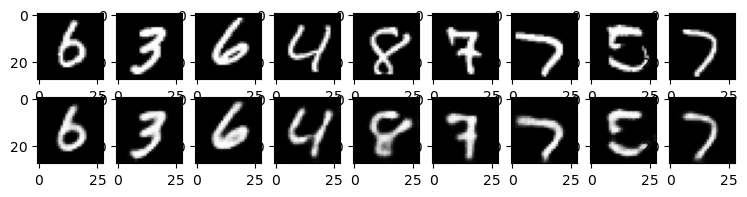

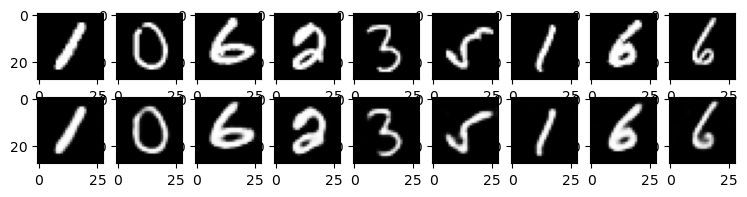

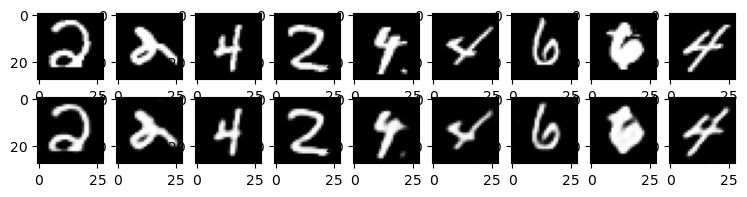

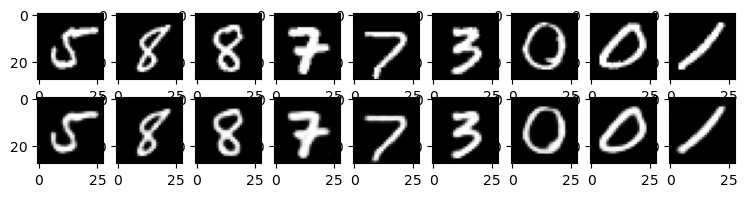

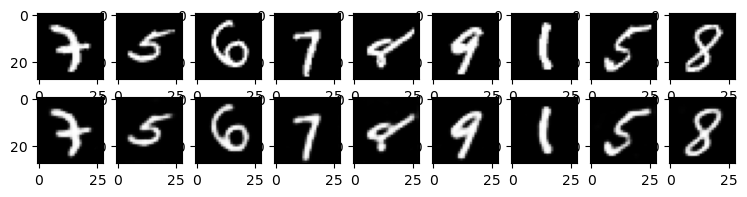

In [32]:
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

### Variational Autoencoder (VAE) Example

credit: 

- https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95
- https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f


In [ ]:
class VAE(AutoEncoder):
    def __init__(self):
        super().__init__()
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)
        # Return the generated samples
        return samples

In [ ]:
class ConditionalVAE(VAE):
    # VAE implementation from the article linked above
    def __init__(self, num_classes):
        super().__init__()
        # Add a linear layer for the class label
        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, self.num_hidden),
            nn.ReLU(),
        )

    def condition_on_label(self, z, y):
        projected_label = self.label_projector(y.float())
        return z + projected_label

    def forward(self, x, y):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(self.condition_on_label(z, y))
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(self.condition_on_label(z, y))
        # Return the generated samples
        return samples

### Conditional VAE Better Example

credit:

- https://github.com/tdrose/medium-articles-code/blob/main/embedding-cvae/01_lightning-cvae.ipynb
- https://github.com/tdrose/medium-articles-code/blob/main/embedding-cvae/02_embedding-cvae.ipynb
- paper: https://www.nature.com/articles/s41592-023-02035-2
- https://github.com/avandekleut/avandekleut.github.io/blob/master/_posts/2020-05-14-vae.md


In [1]:
import torch

digits = torch.tensor([0,1,2,3])
torch.nn.functional.one_hot(digits, 10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import pytorch_lightning as pl

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from utils import plot_latent

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Creating a dataloader
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=False),
        batch_size=128,
        shuffle=True)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, device):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        
        self.kl = 0
        self.device = device

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, device)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder


In [5]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims, device).to(device) # GPU
vae = train_vae(vae, data)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:41<00:00,  2.05s/it]


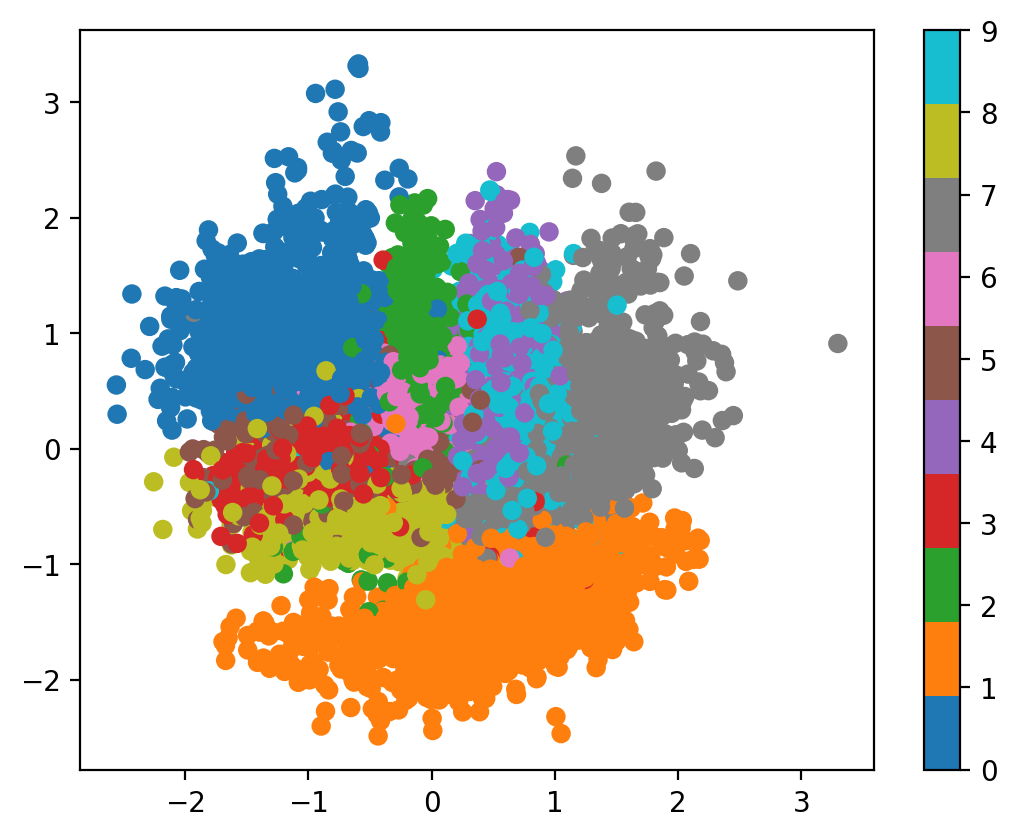

In [6]:
plot_latent(vae, data, device)

In [8]:
class CondVariationalEncoder(nn.Module):
    
    # The encoder gets the label as an one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalEncoder, self).__init__()
        # The dimensions of the one-hot encoding are added concatenated to the input
        self.linear1 = nn.Linear(784 + n_classes, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    # The labels are provided as variable `y`
    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        x = x.view(-1, 1*28*28)
        # Here the label one-hot encoding is concatenated to the image
        x = F.relu(self.linear1(torch.cat((x,y),dim=1)))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
    
class CondVariationalDecoder(nn.Module):
    
    # The decoder gets the label as an one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalDecoder, self).__init__()
        # The dimensions of the one-hot encoding are added concatenated to the input
        self.linear1 = nn.Linear(latent_dims + n_classes, 512)
        self.linear2 = nn.Linear(512, 784)
        
    # Labels are provided as variable `y`
    def forward(self, z, y):
        # Here the label one-hot encoding is concatenated to the image
        z = F.relu(self.linear1(torch.cat((z,y),dim=1)))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


# The full CVAE model also forwards the integer labels
class CondVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalAutoencoder, self).__init__()
        self.encoder = CondVariationalEncoder(latent_dims, n_classes)
        self.decoder = CondVariationalDecoder(latent_dims, n_classes)
    
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)

In [9]:
def train(autoencoder, data, epochs=20, n_classes=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            number = torch.nn.functional.one_hot(torch.tensor(y), num_classes=n_classes).to(device)
            opt.zero_grad()
            x_hat = autoencoder(x, number)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        print(loss)
    return autoencoder

In [10]:
# Model training

# We also use two latent dimensions for a simple visualization of the latent space
# Changin the number of latent dimensions will break the later plotting function
latent_dims=2
cvae = CondVariationalAutoencoder(latent_dims, n_classes=10).to(device) # GPU
cvae = train(cvae, data, n_classes=10)

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_640668/991955673.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  number = torch.nn.functional.one_hot(torch.tensor(y), num_classes=n_classes).to(device)
  5%|▌         | 1/20 [00:02<00:41,  2.16s/it]

tensor(3356.8235, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 2/20 [00:04<00:38,  2.12s/it]

tensor(3233.6040, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 3/20 [00:06<00:36,  2.13s/it]

tensor(2988.5740, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 4/20 [00:08<00:33,  2.12s/it]

tensor(3224.3596, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 5/20 [00:10<00:31,  2.11s/it]

tensor(3038.4897, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 6/20 [00:12<00:29,  2.10s/it]

tensor(3152.3286, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 7/20 [00:14<00:27,  2.10s/it]

tensor(3080.5007, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 8/20 [00:16<00:25,  2.09s/it]

tensor(3133.3652, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 9/20 [00:18<00:22,  2.09s/it]

tensor(3059.2578, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 10/20 [00:20<00:20,  2.07s/it]

tensor(3036.7771, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 11/20 [00:22<00:18,  2.06s/it]

tensor(2976.4038, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 12/20 [00:25<00:16,  2.08s/it]

tensor(2879.2041, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 13/20 [00:27<00:14,  2.10s/it]

tensor(3012.7466, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 14/20 [00:29<00:12,  2.09s/it]

tensor(3096.8020, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 15/20 [00:31<00:10,  2.09s/it]

tensor(2799.9629, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 16/20 [00:33<00:08,  2.08s/it]

tensor(3018.2908, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 17/20 [00:35<00:06,  2.09s/it]

tensor(3136.3926, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 18/20 [00:37<00:04,  2.09s/it]

tensor(3006.4370, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 19/20 [00:39<00:02,  2.10s/it]

tensor(2970.3652, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 20/20 [00:41<00:00,  2.09s/it]

tensor(2912.8213, device='cuda:0', grad_fn=<AddBackward0>)


In [11]:
# In this plotting function we create a grid in the latent space and use this as an input for the decoder
# Additionally, the variable `number` we provide the interger we want the model to generate
def plot_reconstructed(autoencoder, r0=(-5, 5), r1=(-5, 5), n=12, number=2, device='cuda'):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):
            
            z = torch.Tensor([[a, b]]).to(device)
            # One-hot encoding of the integer
            y = torch.nn.functional.one_hot(torch.tensor([number]), num_classes=10).to(device)
            x_hat = autoencoder.decoder(z, y)
            
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

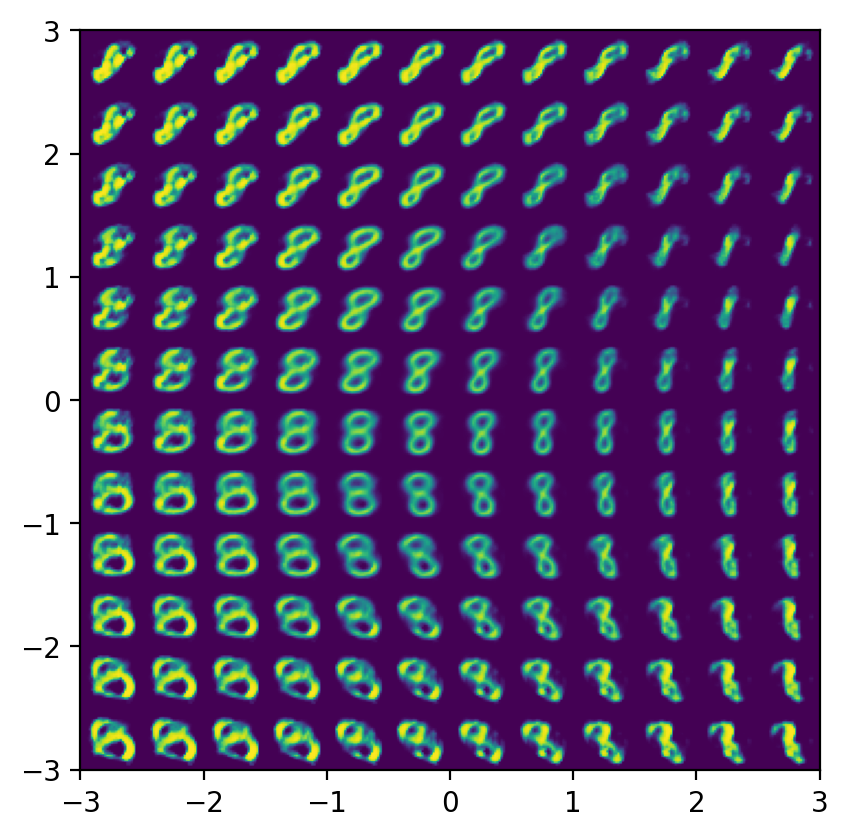

In [12]:
# Generating a variety of 8's from different positions in the latent space.

# Since the VAE loss pushed the model towards a standard normal distribution in the latent space 
# we can just use a grid centered around 0
plot_reconstructed(cvae, r0=(-3, 3), r1=(-3, 3), number=8)

In [13]:
def plot_latent_cvae(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device), torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

/tmp/ipykernel_640668/1995175506.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = autoencoder.encoder(x.to(device), torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device))


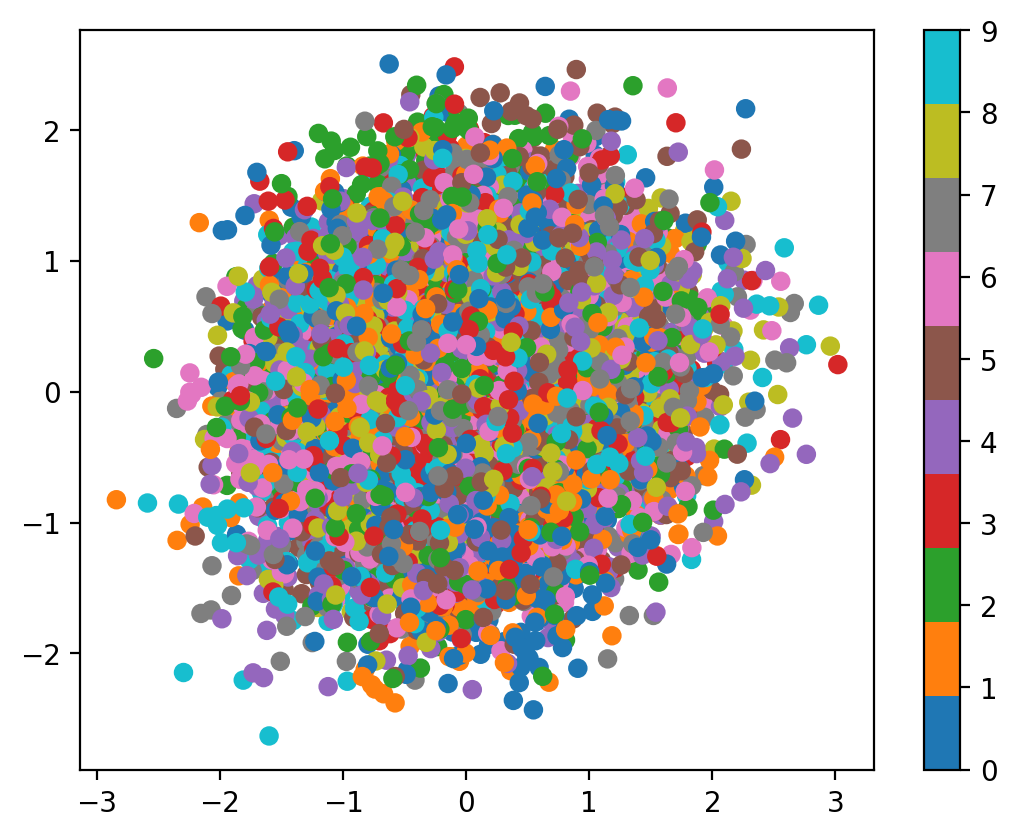

In [14]:
plot_latent_cvae(cvae, data)

### PyTorch Lightning CVAE

In [15]:
# First, we define Lightning module for the CVAE model
class CVAEModel(pl.LightningModule):
    # In the constructor we just use the previously defined CVAE model and number of classes
    def __init__(self, latent_dims, n_classes):
        super().__init__()
        self.cvae = CondVariationalAutoencoder(latent_dims, n_classes)
        self.n_classes = n_classes

    # Lightning requires a training step function in which the forward step is executed and loss calculated
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_oh = torch.nn.functional.one_hot(y, num_classes=self.n_classes)
        
        
        x_hat = self.cvae(x, y_oh)
        loss = loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl
        
        # For to see the loss during training, we add the current loss to the logger
        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)
        
        return loss
    
    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [16]:
# Training of the model
latent_dims=2
model = CVAEModel(latent_dims=latent_dims, n_classes=10)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                       | Params | Mode 
------------------------------------------------------------
0 | cvae | CondVariationalAutoencoder | 817 K  | train
------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.272     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
/home/gojian/Programs/Mamba/envs/awg/lib/pyth

Epoch 19: 100%|██████████| 469/469 [00:02<00:00, 172.64it/s, v_num=15, Training loss=4.26e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:02<00:00, 171.88it/s, v_num=15, Training loss=4.26e+3]


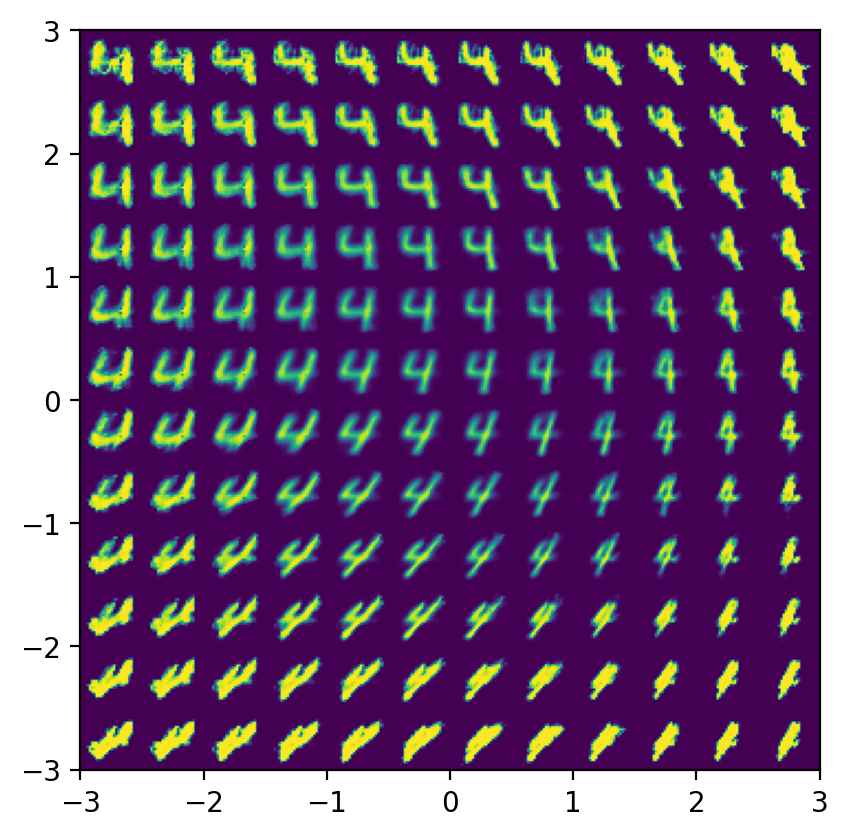

In [17]:
# Lightning is sending the model to the cpu after training, therefore we need to send it back to the gpu
model.to('cuda')
# Visualization of the latent space as shown previously after training
plot_reconstructed(model.cvae, r0=(-3, 3), r1=(-3, 3), number=4, device='cuda')

### CVAE with embeddings as conditional variables


In [19]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import pytorch_lightning as pl

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from utils import plot_latent, plot_reconstructed_ecvae

%load_ext autoreload
%autoreload 2

In [20]:
ds = torchvision.datasets.MNIST('./data',
                                transform=torchvision.transforms.ToTensor(),
                                download=False)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Creating a dataloader
data = torch.utils.data.DataLoader(
        ds,
        batch_size=128,
        shuffle=True)

In [22]:
from utils import CondVariationalAutoencoder

class eCVAEModel(pl.LightningModule):
    # Here we need to define the number of classes and embedding dimensions
    def __init__(self, latent_dims, n_classes, embedding_dims):
        super().__init__()
        # We can use the CVAE model from the previous notebook, but instead of using the number of classes for a one-hot encoding,
        # we use the embedding dimensions
        self.cvae = CondVariationalAutoencoder(latent_dims, embedding_dims)
        self.n_classes = n_classes
        self.embedding_dims = embedding_dims
        self.embed_cond = nn.Embedding(num_embeddings=n_classes, embedding_dim=embedding_dims, max_norm=True)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Instead of a one-hot encoding, the embeddings are used as conditional variables
        x_hat = self.cvae(x, self.embed_cond(y))
        loss = loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl
        
        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)
        
        return loss
    
    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [23]:
latent_dims=2

In [24]:
# Training of the model

model = eCVAEModel(latent_dims=latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params | Mode 
------------------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K  | train
1 | embed_cond | Embedding                  | 50     | train
------------------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/gojian/Programs/Mamba/envs/awg/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 469/469 [00:02<00:00, 169.63it/s, v_num=16, Training loss=4.34e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:02<00:00, 168.96it/s, v_num=16, Training loss=4.34e+3]


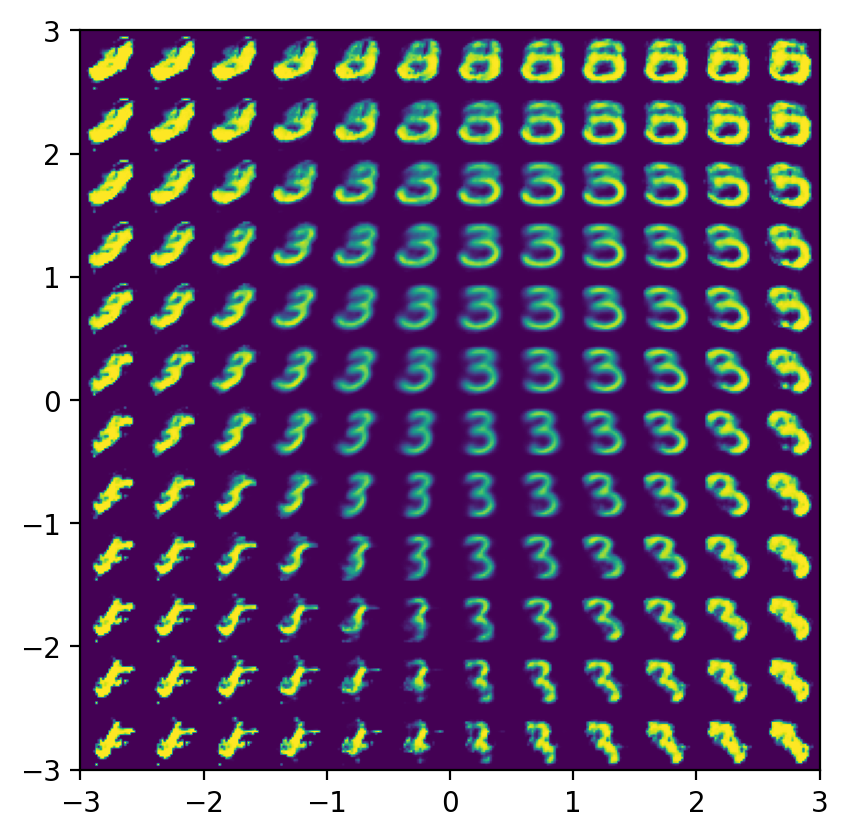

In [25]:
# Lightning is sending the model to the cpu after training, therefore we need to send it back to the gpu
model.to('cuda')

# Visualization of the latent space as shown previously after training
# This is a slightly modified function compared to the previous notebook, check the `utils.py` file.
plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3), number=3, device='cuda')

### Demonstration of CVAE training model on a subset of data only


In [28]:
# Creating dataloaders excluding 8 & 9 digits
# Code adapted from: https://stackoverflow.com/questions/75034387/remove-digit-from-mnist-pytorch
dstrain = torchvision.datasets.MNIST('./data',
                                transform=torchvision.transforms.ToTensor(),
                                download=False)
idxn9 = dstrain.targets!=9
idxn8 = dstrain.targets!=8

idx = idxn9 & idxn8

dstrain.targets = dstrain.targets[idx]
dstrain.data = dstrain.data[idx]

# Data containing only 8 & 9 digits
ds89 = torchvision.datasets.MNIST('./data',
                                transform=torchvision.transforms.ToTensor(),
                                download=True)
idx9 = ds89.targets==9
idx8 = ds89.targets==8

idx89 = idx9 | idx8

ds89.targets = ds89.targets[idx89]
ds89.data = ds89.data[idx89]

In [29]:
datatrain = torch.utils.data.DataLoader(dstrain, batch_size=128, shuffle=True)
data89 = torch.utils.data.DataLoader(ds89, batch_size=128, shuffle=True)

In [30]:
# Training of the model
latent_dims=2
model = eCVAEModel(latent_dims=latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(model, datatrain)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params | Mode 
------------------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K  | train
1 | embed_cond | Embedding                  | 50     | train
------------------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/gojian/Programs/Mamba/envs/awg/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 377/377 [00:02<00:00, 157.81it/s, v_num=17, Training loss=4.28e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 377/377 [00:02<00:00, 157.06it/s, v_num=17, Training loss=4.28e+3]


In [31]:
# Check if the model parameters are actually frozen
tmp = list(model.named_parameters())[0][1].detach().numpy()

In [32]:
# Freeze model parameters
for name, param in model.named_parameters():
    if name == 'embed_cond.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False

# Training just on 8 & 9 digits on frozen weights
# The model is using the previously created embedding vectors in the model that were not updated for 8 & 9 in the previous training.
trainer89 = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer89.fit(model, data89)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params | Mode 
------------------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K  | train
1 | embed_cond | Embedding                  | 50     | train
------------------------------------------------------------------
50        Trainable params
812 K     Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 93/93 [00:00<00:00, 161.18it/s, v_num=18, Training loss=5.67e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 93/93 [00:00<00:00, 159.18it/s, v_num=18, Training loss=5.67e+3]


In [33]:
# Check if model weights were not changed
(list(model.named_parameters())[0][1].detach().numpy() == tmp).all()

np.True_

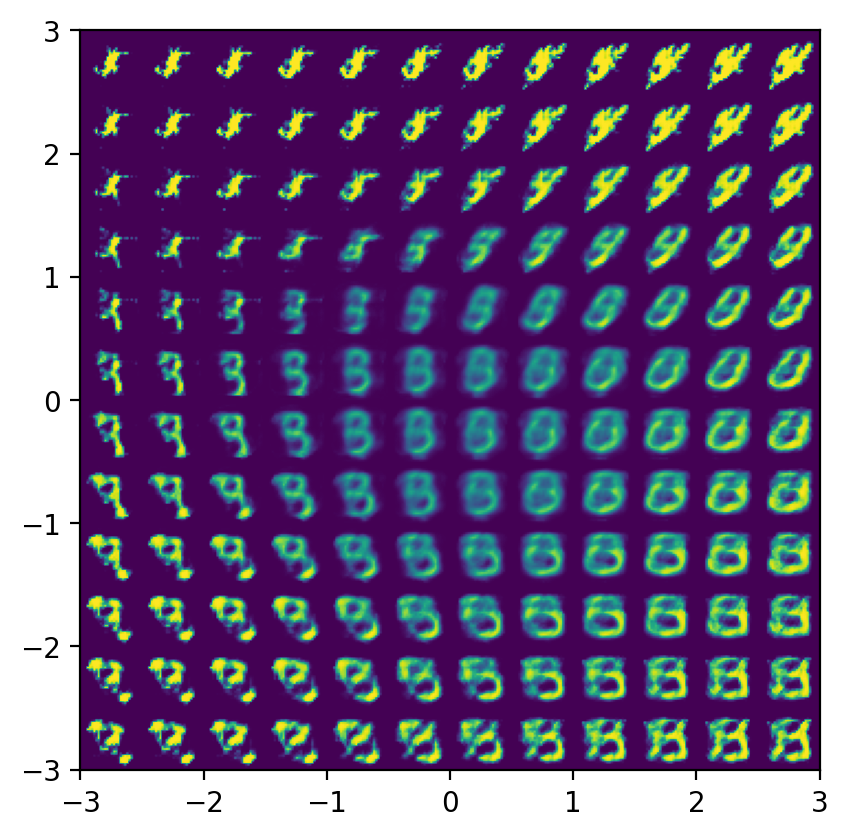

In [34]:
model.to('cuda')

# Visualization of the latent space as shown previously after training
# This is a slightly modified function compared to the previous notebook, check the `utils.py` file.
plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3), number=8, device='cuda')

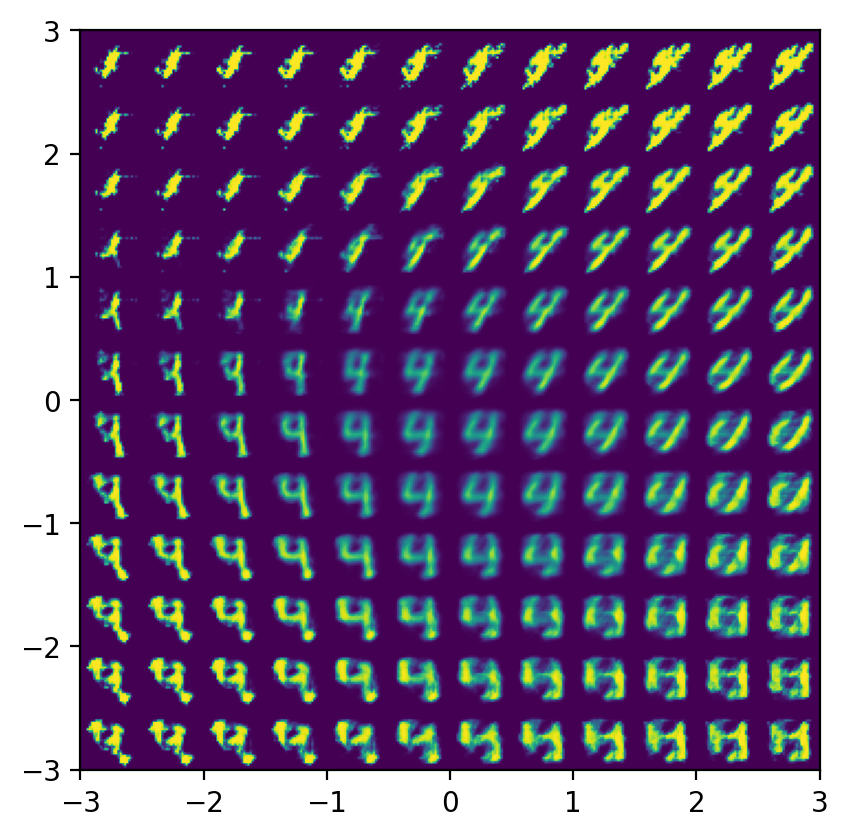

In [35]:
model.to('cuda')

# Visualization of the latent space as shown previously after training
# This is a slightly modified function compared to the previous notebook, check the `utils.py` file.
plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3), number=9, device='cuda')